# Identifying Spam from SMS Text Messages

This analysis attempts to identify spam messages from a corpus of 5,574 SMS text messages.  The corpus is labeled as either spam or ham (legitimate messages) with 4,827 as ham and 747 as spam.  Using Sci-kit Learn and the Multinomial Naive Bayes model to classify messages as spam and ham.

We will look at various options to tune the model to see if we can get to 0 false positives in which legitimate messages are labled as spam.  It is expected that a small percentage of spam messages making it through the spam filter is preferable to legitimate messages being excluded.

Sources:

https://archive.ics.uci.edu/ml/datasets/sms+spam+collection

https://radimrehurek.com/data_science_python/

http://adataanalyst.com/scikit-learn/countvectorizer-sklearn-example/

In [479]:
%matplotlib inline

import os
import json
import time
import pickle
import requests
from io import BytesIO
from zipfile import ZipFile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text

import seaborn as sns
sns.set(font_scale=1.5)

### Loading the data from the UCI Machine Learning Repository

In [517]:

URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
SMS_PATH = os.path.join('datasets', 'sms')

file_name = requests.get(URL)
zipfile = ZipFile(BytesIO(file_name.content))
zip_names = zipfile.namelist()

def fetch_data(file='SMSSPamCollection'):
    for file in zip_names:
        if not os.path.isdir(SMS_PATH):
            os.makedirs(SMS_PATH)
        outpath = os.path.join(SMS_PATH, file)
        extracted_file = zipfile.read(file)
        with open(outpath, 'wb') as f:
            f.write(extracted_file)           
        
        return outpath
               
DATA = fetch_data()

In [518]:
df = pd.read_csv(DATA, sep='\t', header=None)

In [519]:
df.columns = ['Label', 'Text']

# Data Exploration

In [520]:
pd.set_option('max_colwidth', 220)
df.head(20)

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"
5,spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv"
6,ham,Even my brother is not like to speak with me. They treat me like aids patent.
7,ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
8,spam,WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
9,spam,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030


In [521]:
df.describe()

,Label,Text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [522]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
Label    5572 non-null object
Text     5572 non-null object
dtypes: object(2)
memory usage: 87.1+ KB


### Since the data is labeled for us, we can do further data exploration by taking a look at how spam and ham differ.

In [523]:
# Add a field to our dataframe with the length of each message.

df['Length'] = df['Text'].apply(len)

In [524]:
df.head()

,Label,Text,Length
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives around here though",61


In [525]:
df.groupby('Label').describe()

Length                                                         
        count        mean        std   min    25%    50%    75%    max
Label                                                                 
ham    4825.0   71.482487  58.440652   2.0   33.0   52.0   93.0  910.0
spam    747.0  138.670683  28.873603  13.0  133.0  149.0  157.0  223.0

### In addition to the difference in the number of ham vs. spam, it appears that spam messages are generally longer than spam messages and more normally distributed than ham messages.

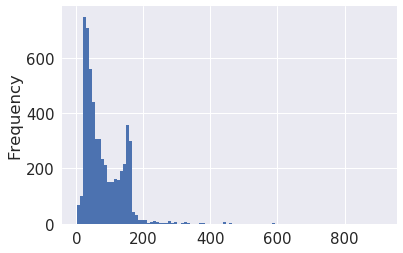

In [526]:
df.Length.plot(bins=100, kind='hist')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4c7cdd5860>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f4c7cfb7748>], dtype=object)

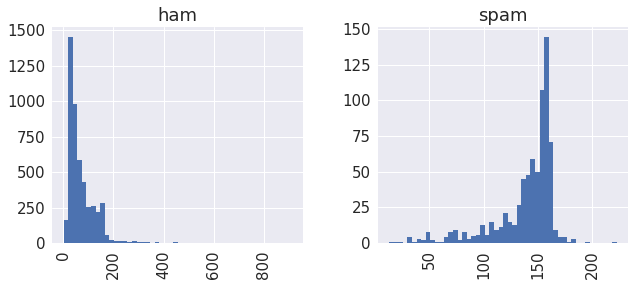

In [527]:
df.hist(column='Length', by='Label', bins=50, figsize=(10,4))

# Define the feature set through vectorization.

In [528]:
text_data = df['Text']
text_data.shape

(5572,)

In [529]:
# Give our target labels numbers.

df['Label_'] = df['Label'].map({'ham': 0, 'spam': 1})

In [530]:
#stop_words = text.ENGLISH_STOP_WORDS

#Adding stop words did not significantly improve the model.

In [531]:
#textWithoutNums = text_data.replace('\d+', 'NUM_', regex=True)

#Removing all of the numbers in the messages and replacing with a text string did not improve the model either.

In [532]:
vectorizer = CountVectorizer(analyzer='word') #, stop_words=stop_words)
#vectorizer.fit(textWithoutNums)
vectorizer.fit(text_data)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [533]:
vectorizer.get_feature_names()

['00',
 '000',
 '000pes',
 '008704050406',
 '0089',
 '0121',
 '01223585236',
 '01223585334',
 '0125698789',
 '02',
 '0207',
 '02072069400',
 '02073162414',
 '02085076972',
 '021',
 '03',
 '04',
 '0430',
 '05',
 '050703',
 '0578',
 '06',
 '07',
 '07008009200',
 '07046744435',
 '07090201529',
 '07090298926',
 '07099833605',
 '07123456789',
 '0721072',
 '07732584351',
 '07734396839',
 '07742676969',
 '07753741225',
 '0776xxxxxxx',
 '07781482378',
 '07786200117',
 '077xxx',
 '078',
 '07801543489',
 '07808',
 '07808247860',
 '07808726822',
 '07815296484',
 '07821230901',
 '078498',
 '07880867867',
 '0789xxxxxxx',
 '07946746291',
 '0796xxxxxx',
 '07973788240',
 '07xxxxxxxxx',
 '08',
 '0800',
 '08000407165',
 '08000776320',
 '08000839402',
 '08000930705',
 '08000938767',
 '08001950382',
 '08002888812',
 '08002986030',
 '08002986906',
 '08002988890',
 '08006344447',
 '0808',
 '08081263000',
 '08081560665',
 '0825',
 '083',
 '0844',
 '08448350055',
 '08448714184',
 '0845',
 '08450542832',
 '084

In [534]:
pd.DataFrame.from_dict(vectorizer.vocabulary_, orient='index').sort_values(by=0, ascending=False).head()

,0
〨ud,8712
ú1,8711
èn,8710
zyada,8709
zouk,8708


In [535]:
dtm = vectorizer.transform(text_data)
features = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names())
features.shape

(5572, 8713)

In [536]:
features.head()

,00,000,000pes,008704050406,0089,0121,01223585236,01223585334,0125698789,02,...,zhong,zindgi,zoe,zogtorius,zoom,zouk,zyada,èn,ú1,〨ud
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [537]:
X = features
y = np.array(df['Label_'].tolist())

In [538]:
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train.shape, y_train.shape)

(4457, 8713) (4457,)


In [539]:
model = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
model.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [540]:
y_pred_class = model.predict(X_test)

In [541]:
print(metrics.classification_report(y_test, y_pred_class))
print('Accuracy Score: ', metrics.accuracy_score(y_test, y_pred_class))

             precision    recall  f1-score   support

          0       0.99      0.99      0.99       968
          1       0.95      0.97      0.96       147

avg / total       0.99      0.99      0.99      1115

Accuracy Score:  0.989237668161


### Using Yellowbrick

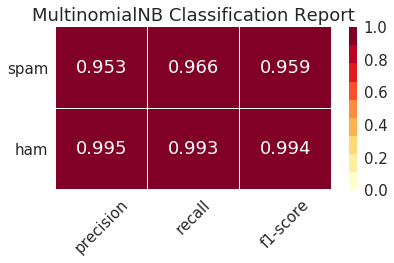

In [542]:
from yellowbrick.classifier import ClassificationReport
bayes = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
visualizer = ClassificationReport(bayes, classes=['ham', 'spam'])
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
g = visualizer.poof()

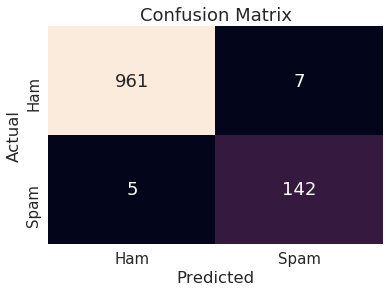

In [543]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_class)
sns.set(font_scale=1.5)

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt='g', cbar=False)


ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Ham', 'Spam'])
ax.yaxis.set_ticklabels(['Ham', 'Spam'])
plt.show()

### Using the default settings for our model does a pretty good job predicting spam and ham although not perfect.  The confusion matrix shows us that there are 12 false positives ( 5 actual spam messages that are predicted to be ham with 7 actual ham message predicted as spam).

### I think it is more important to a user to receive 100% of their real messages while tolerating a few spam messages.  So let's see if we can tune the model to eliminate the false positives that are tagged as spam but are really ham.

### We can use grid search with cross-validation to find the optimal alpha value.

In [544]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Split the dataset in two equal parts
X_train_, X_test_, y_train_, y_test_ = train_test_split(
    X, y, test_size=0.5, random_state=1)

# Set the parameters by cross-validation
tuned_parameters = [{'alpha': [0.5, 1.0, 1.5, 2.0, 2.5, 3.0], 'class_prior':[None], 'fit_prior': [True, False]}]

scores = ['precision', 'recall']

for score in scores:
    print("### Tuning hyper-parameters for %s ###" % score)
    print()

    clf = GridSearchCV(MultinomialNB(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train_, y_train_)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    print('Accuracy Score: ', metrics.accuracy_score(y_test, y_pred))
    print()

### Tuning hyper-parameters for precision ###

Best parameters set found on development set:

{'alpha': 3.0, 'class_prior': None, 'fit_prior': True}

Grid scores on development set:

0.950 (+/-0.028) for {'alpha': 0.5, 'class_prior': None, 'fit_prior': True}
0.897 (+/-0.039) for {'alpha': 0.5, 'class_prior': None, 'fit_prior': False}
0.966 (+/-0.023) for {'alpha': 1.0, 'class_prior': None, 'fit_prior': True}
0.913 (+/-0.041) for {'alpha': 1.0, 'class_prior': None, 'fit_prior': False}
0.972 (+/-0.015) for {'alpha': 1.5, 'class_prior': None, 'fit_prior': True}
0.925 (+/-0.020) for {'alpha': 1.5, 'class_prior': None, 'fit_prior': False}
0.973 (+/-0.019) for {'alpha': 2.0, 'class_prior': None, 'fit_prior': True}
0.927 (+/-0.027) for {'alpha': 2.0, 'class_prior': None, 'fit_prior': False}
0.973 (+/-0.017) for {'alpha': 2.5, 'class_prior': None, 'fit_prior': True}
0.931 (+/-0.029) for {'alpha': 2.5, 'class_prior': None, 'fit_prior': False}
0.974 (+/-0.017) for {'alpha': 3.0, 'class_prior': N

### Since we are more concerned with minimizing the false positives especially with ham classified as spam, we will use an alpha value of 3.0 with fit_prior = True.

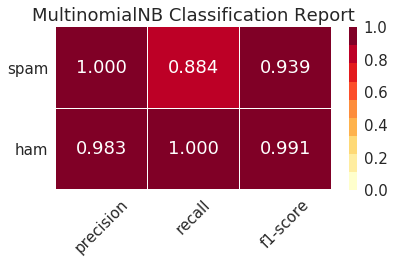

In [545]:
from yellowbrick.classifier import ClassificationReport
bayes = MultinomialNB(alpha=3.0, class_prior=None, fit_prior=True)
visualizer = ClassificationReport(bayes, classes=['ham', 'spam'])
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
g = visualizer.poof()

In [546]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train.shape, y_train.shape)

(4457, 8713) (4457,)


In [547]:
model = MultinomialNB(alpha=3.0, class_prior=None, fit_prior=True)
model.fit(X_train, y_train)

MultinomialNB(alpha=3.0, class_prior=None, fit_prior=True)

In [548]:
y_pred_class = model.predict(X_test)

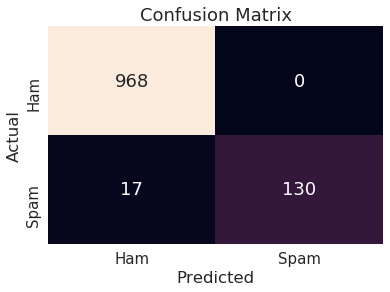

In [549]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_class)
sns.set(font_scale=1.5)

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt='g', cbar=False)


ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Ham', 'Spam'])
ax.yaxis.set_ticklabels(['Ham', 'Spam'])
plt.show()

### By using the optimal alpha value for precision, we are able to eliminate the false positives of messages predicted to be spam but are actually ham at the expense of receiving more spam messages that are incorrectly labeled as ham. 